# 계층적 군집

**Hierarchical Clustering**

## #01. 패키지

모델 : scipy.cluster.AgglomerativeClustering

거리계산 : scipy.cluster.hierarchy.linkage

시각화 : scipy.cluster.hierarchy.dendrogram

평가 : sklearn.metrics.silhouette_score , silhouette_samples, yellowbrick.cluster.KElbowVisualizer

In [1]:
import sys
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from pandas import read_excel, DataFrame

# sklearn은 AgglomerativeClustering() 함수를 제공
from sklearn.cluster import AgglomerativeClustering

# 표준화
from sklearn.preprocessing import MinMaxScaler

In [3]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## #02. 데이터

In [2]:
origin = read_excel("행정동병합최종.xlsx")
origin.head()

,시도명,시군구코드,시군구명,행정동코드,행정동코드_수정,읍면동명,생성일자,말소일자,지하철역_수,의료기관_수,...,보육시설수,세대당공원면적minmax,수변점수,행정동별버스정류장수,행정동별유통업체수,공공자전거대여소수,여가생활지수minmax,사회적약자지수minmax,접근성지수minmax,그린지수minmax
0,서울특별시,11110,종로구,1111051500,11110515,청운효자동,20081101,0,0,11,...,4,0.352898,0,32,0,3,0.002648,0.051957,0.176381,0.187151
1,서울특별시,11110,종로구,1111053000,11110530,사직동,19880423,0,2,75,...,0,0.063554,0,27,0,12,0.006464,0.033809,0.351000,0.033704
2,서울특별시,11110,종로구,1111054000,11110540,삼청동,19880423,0,0,11,...,3,1.000000,0,16,0,5,0.005332,0.063374,0.506800,0.530328
3,서울특별시,11110,종로구,1111055000,11110550,부암동,19880423,0,0,4,...,3,0.000000,10,34,0,5,0.001699,0.051612,0.236014,0.530328
4,서울특별시,11110,종로구,1111056000,11110560,평창동,19880423,0,0,15,...,3,0.001192,10,54,0,5,0.000529,0.057453,0.231581,0.530960


## #03. 데이터 전처리

### 필요한 데이터만 추출

In [4]:
origin.columns

Index(['시도명', '시군구코드', '시군구명', '행정동코드', '행정동코드_수정', '읍면동명', '생성일자', '말소일자',
       '지하철역_수', '의료기관_수', '사회복지시설_수', '계_명', '면적', '구성비', '행정동별_공원수',
       '공공체육시설_수', '문화시설_수', '학교_수', '사업체_수', '개소', '면수', '하천및한강여부', '아동인구',
       '노인인구', '장애인_인구', '세대당공원면적', '보육시설수', '세대당공원면적minmax', '수변점수',
       '행정동별버스정류장수', '행정동별유통업체수', '공공자전거대여소수', '여가생활지수minmax', '사회적약자지수minmax',
       '접근성지수minmax', '그린지수minmax'],
      dtype='object')

In [5]:
df = origin.filter([
    '지하철역_수', '의료기관_수', '사회복지시설_수', '계_명', '면적', '구성비', 
    '행정동별_공원수', '공공체육시설_수', '문화시설_수', '학교_수', '사업체_수', '개소', 
    '면수', '하천및한강여부', '아동인구', '노인인구', '장애인_인구', '세대당공원면적', 
    '보육시설수', '세대당공원면적minmax', '수변점수', '행정동별버스정류장수', 
    '여가생활지수minmax', '사회적약자지수minmax', '접근성지수minmax', '그린지수minmax'
])
df.head()

,지하철역_수,의료기관_수,사회복지시설_수,계_명,면적,구성비,행정동별_공원수,공공체육시설_수,문화시설_수,학교_수,...,장애인_인구,세대당공원면적,보육시설수,세대당공원면적minmax,수변점수,행정동별버스정류장수,여가생활지수minmax,사회적약자지수minmax,접근성지수minmax,그린지수minmax
0,0,11,5,11700,2.57,0.42,2,10,6,8,...,437,337.55,4,0.352898,0,32,0.002648,0.051957,0.176381,0.187151
1,2,75,1,9362,1.23,0.20,3,8,13,2,...,267,60.79,0,0.063554,0,27,0.006464,0.033809,0.351000,0.033704
2,0,11,0,2576,1.49,0.25,1,2,31,2,...,110,956.51,3,1.000000,0,16,0.005332,0.063374,0.506800,0.530328
3,0,4,4,9377,2.27,0.38,1,5,5,4,...,311,0.00,3,0.000000,10,34,0.001699,0.051612,0.236014,0.530328
4,0,15,11,17658,8.87,1.47,0,5,11,4,...,491,1.14,3,0.001192,10,54,0.000529,0.057453,0.231581,0.530960


In [6]:
df = df.fillna(0)
df.isna().sum()

지하철역_수           0
의료기관_수           0
사회복지시설_수         0
계_명              0
면적               0
구성비              0
행정동별_공원수         0
공공체육시설_수         0
문화시설_수           0
학교_수             0
사업체_수            0
개소               0
면수               0
하천및한강여부          0
아동인구             0
노인인구             0
장애인_인구           0
세대당공원면적          0
보육시설수            0
세대당공원면적minmax    0
수변점수             0
행정동별버스정류장수       0
여가생활지수minmax     0
사회적약자지수minmax    0
접근성지수minmax      0
그린지수minmax       0
dtype: int64

#### 분석에 사용될 지수 추출

`minmax로 scaling한 지수`를 분석에 사용

In [7]:
X = df.copy()
X = X.filter(['여가생활지수minmax', '사회적약자지수minmax', '접근성지수minmax', '그린지수minmax'])
X.head()

,여가생활지수minmax,사회적약자지수minmax,접근성지수minmax,그린지수minmax
0,0.002648,0.051957,0.176381,0.187151
1,0.006464,0.033809,0.351000,0.033704
2,0.005332,0.063374,0.506800,0.530328
3,0.001699,0.051612,0.236014,0.530328
4,0.000529,0.057453,0.231581,0.530960


#### 지수의 결측치 확인 및 처리

In [8]:
X.isna().sum()

여가생활지수minmax     0
사회적약자지수minmax    0
접근성지수minmax      0
그린지수minmax       0
dtype: int64

In [9]:
# X = X.fillna(0)
# X.isna().sum()

#### 이상치(`int`) 유무 확인

In [10]:
is_inf = X.isin([np.inf, -np.inf])

# 각 column별로 -inf 또는 inf 값을 포함하고 있는 행 수를 확인
inf_count = is_inf.sum()

# 결과 출력
inf_count

여가생활지수minmax     0
사회적약자지수minmax    0
접근성지수minmax      0
그린지수minmax       0
dtype: int64

In [11]:
X.columns

Index(['여가생활지수minmax', '사회적약자지수minmax', '접근성지수minmax', '그린지수minmax'], dtype='object')

### 분석용 데이터 스케일링

In [12]:
scaler = MinMaxScaler()
n_data = scaler.fit_transform(X)
n_data[:5]

array([[2.64751750e-03, 5.19574059e-02, 1.76380830e-01, 1.87151396e-01],
       [6.46393211e-03, 3.38089072e-02, 3.50999695e-01, 3.37044389e-02],
       [5.33216587e-03, 6.33738658e-02, 5.06799703e-01, 5.30327896e-01],
       [1.69869928e-03, 5.16119276e-02, 2.36014323e-01, 5.30327896e-01],
       [5.28773115e-04, 5.74526172e-02, 2.31580705e-01, 5.30959958e-01]])

In [13]:
ndf = DataFrame(n_data, columns=X.columns)
ndf.head()

,여가생활지수minmax,사회적약자지수minmax,접근성지수minmax,그린지수minmax
0,0.002648,0.051957,0.176381,0.187151
1,0.006464,0.033809,0.351000,0.033704
2,0.005332,0.063374,0.506800,0.530328
3,0.001699,0.051612,0.236014,0.530328
4,0.000529,0.057453,0.231581,0.530960


> 전원 수치 데이터임으로 별도의 라벨링이 필요 없다고 판단.

## #04. 계층 군집 수행

### 1. scipy 패키지 사용

scipy는 모델 생성/시각화 과정이 반자동이지만 sklearn은 수동으로 설정(공식으로 판단할 것)

linkage : 거리 측정 방법 지정<br/>
기본 값 : `ward`<br/>
그 외 값 : ‘ward’, ‘complete’, ‘average’, ‘single’

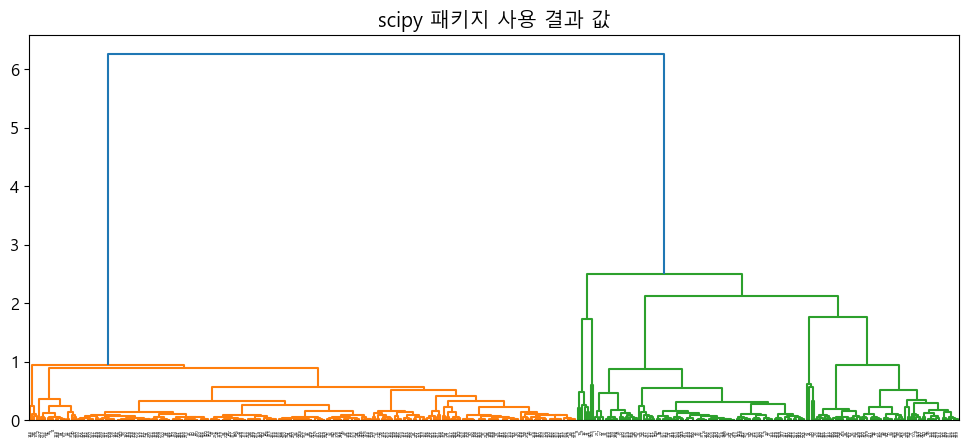

In [14]:
lnk = linkage(ndf, method="ward")
plt.figure(figsize=(12,5))
dendrogram(lnk, show_leaf_counts=True)
plt.xticks(fontsize=3)  # 원하는 글자 크기로 설정
plt.title("scipy 패키지 사용 결과 값")
plt.show()
plt.close()

### 2. sklearn 패키지 사용

n_clusters : 찾아야 할 클러스터 수(earlystopping과 유사)

affinity : 클러스터 간 거리 측정 방법(euclidean, cityblock, manhattan, cosine)

linkage : ward(기본값), complete, average, single

compute_distances : 노드간의 거리 계산값을 저장할지 여부(시각화를 위해서는 True를 필수 적용)

`n_clusters`은 K-Means에서 엘보우 그래프로 확인된 `4`를 사용.

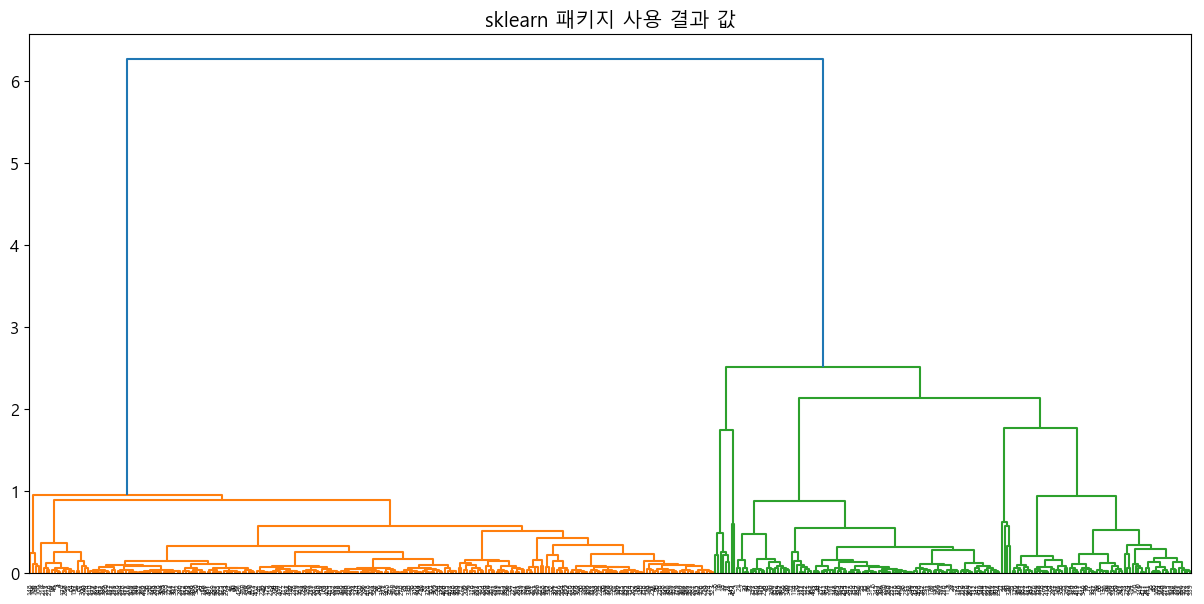

In [15]:
# 모델 객체 생성
ac = AgglomerativeClustering(n_clusters=4,  # 찾아야 할 클러스터 수(earlystopping과 유사)
                             metric='euclidean',  # 클러스터 간 거리 측정 방법
                             linkage='ward',    # 거리측정 방법
                             compute_distances=True #시각화를 위하 반드시 필요
                             )
# clustering = ac.fit(n_data) #학습

clustering = ac.fit(ndf) #학습
# print(clustering.labels_)   #학습결과 확인

# scipy는 아래의 과정을 자동으로 수행, sklearn은 수동으로 설정(공식으로 판단할 것)
counts = np.zeros(clustering.children_.shape[0])    #zeros 모든 원소가 0인 요소
n_samples = len(clustering.labels_)

# 자식 노드를 반복하면서 점을 찍어준다(자식이 몇개 있는지 확인하는 과정)
for i, merge in enumerate(clustering.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# 자식 노드의 수를 저장하는 배열
linkage_matrix = np.column_stack(
    [clustering.children_, clustering.distances_, counts]
).astype(float)

# plt를 설정하지 않으면 쓸데 없는 값도 함께 추출됨
# dendrogram(linkage_matrix)

plt.figure(figsize=(15,7))
dendrogram(linkage_matrix)
plt.title("sklearn 패키지 사용 결과 값")
plt.show()
plt.close()

### sklearn, scipy의 차이를 설명

### 군집수를 4로 설정한 분류 결과값

In [18]:
unique_labels = list(set(clustering.labels_))
unique_labels

[0, 1, 2, 3]

### 분류 결과를 DataFrame과 결합

> 군집(label)을 포함한 DF 생성. <br/> labels를 hue로 잡고 진행하면 군집의 분류 결과를 알 수 있기 때문.

In [19]:
df['계층군집_결과'] = clustering.labels_
df.head()

,지하철역_수,의료기관_수,사회복지시설_수,계_명,면적,구성비,행정동별_공원수,공공체육시설_수,문화시설_수,학교_수,...,세대당공원면적,보육시설수,세대당공원면적minmax,수변점수,행정동별버스정류장수,여가생활지수minmax,사회적약자지수minmax,접근성지수minmax,그린지수minmax,계층군집_결과
0,0,11,5,11700,2.57,0.42,2,10,6,8,...,337.55,4,0.352898,0,32,0.002648,0.051957,0.176381,0.187151,0
1,2,75,1,9362,1.23,0.20,3,8,13,2,...,60.79,0,0.063554,0,27,0.006464,0.033809,0.351000,0.033704,3
2,0,11,0,2576,1.49,0.25,1,2,31,2,...,956.51,3,1.000000,0,16,0.005332,0.063374,0.506800,0.530328,1
3,0,4,4,9377,2.27,0.38,1,5,5,4,...,0.00,3,0.000000,10,34,0.001699,0.051612,0.236014,0.530328,1
4,0,15,11,17658,8.87,1.47,0,5,11,4,...,1.14,3,0.001192,10,54,0.000529,0.057453,0.231581,0.530960,1


In [21]:
df.columns

Index(['지하철역_수', '의료기관_수', '사회복지시설_수', '계_명', '면적', '구성비', '행정동별_공원수',
       '공공체육시설_수', '문화시설_수', '학교_수', '사업체_수', '개소', '면수', '하천및한강여부', '아동인구',
       '노인인구', '장애인_인구', '세대당공원면적', '보육시설수', '세대당공원면적minmax', '수변점수',
       '행정동별버스정류장수', '여가생활지수minmax', '사회적약자지수minmax', '접근성지수minmax',
       '그린지수minmax', '계층군집_결과'],
      dtype='object')

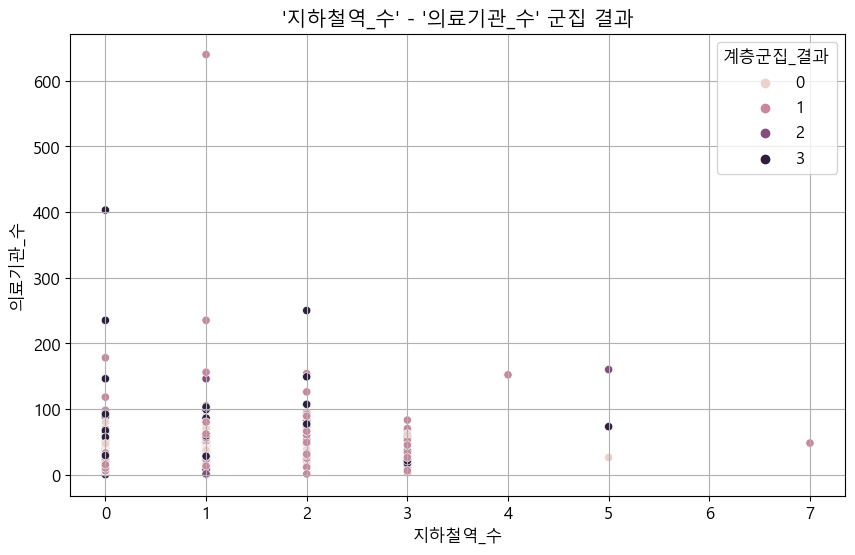

In [26]:
plt.figure(figsize=(10,6))
# #sb.scatterplot(x=n_data[, 0], y=n_data[, 1])
sb.scatterplot(data=df, x='지하철역_수', y='의료기관_수', hue='계층군집_결과')
plt.title("'지하철역_수' - '의료기관_수' 군집 결과")
plt.grid()
plt.show()
plt.close()